In [3]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import matplotlib.pyplot as plt

In [4]:
datafile = '/content/Healthcare Providers.csv'
data = pd.read_csv(datafile)

1. Data Cleaning and Transformation

In [5]:
# 1.1 Handle missing values
# For numerical columns: Impute using median or KNN imputation
numerical_cols = data.select_dtypes(include=['number']).columns
numerical_imputer = SimpleImputer(strategy='median')
data[numerical_cols] = numerical_imputer.fit_transform(data[numerical_cols])

# For categorical columns: Impute using the mode or "unknown" placeholder
categorical_cols = data.select_dtypes(include=['object']).columns
categorical_imputer = SimpleImputer(strategy='most_frequent')
data[categorical_cols] = categorical_imputer.fit_transform(data[categorical_cols])

# Remove redundant features
# Drop columns with excessive missing data (>50%)
data = data.loc[:, data.isnull().mean() < 0.5]

# Eliminate non-informative fields like unique identifiers
non_informative_columns = ['ID', 'Provider_ID']  # Example columns, replace with actual unique identifiers
data = data.drop(columns=[col for col in non_informative_columns if col in data.columns], errors='ignore')

# Standardize formats for categorical data
data[categorical_cols] = data[categorical_cols].apply(lambda x: x.str.lower().str.strip() if x.dtype == "object" else x)


2. Encoding Categorical Variables

In [6]:
#Use Label Encoding for low-cardinality features
low_cardinality_features = [col for col in categorical_cols if data[col].nunique() <= 10]
label_encoders = {col: LabelEncoder() for col in low_cardinality_features}
for col, le in label_encoders.items():
    data[col] = le.fit_transform(data[col])

# Use Frequency Encoding for high-cardinality features
high_cardinality_features = [col for col in categorical_cols if data[col].nunique() > 10]
for col in high_cardinality_features:
    freq_encoding = data[col].value_counts().to_dict()
    data[col] = data[col].map(freq_encoding)

3. Feature Scaling and Normalization

In [7]:
# Apply StandardScaler for numerical columns
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Use log transformation for skewed features
skewed_cols = [col for col in numerical_cols if data[col].skew() > 1]
# Check if skewed_cols is empty before applying log transformation
if skewed_cols:  # Proceed only if skewed_cols is not empty
    log_transformer = FunctionTransformer(np.log1p, validate=True)
    data[skewed_cols] = log_transformer.fit_transform(data[skewed_cols])


4. Outlier Detection and Handling

In [8]:
# Identify outliers using z-scores
from scipy.stats import zscore
z_scores = np.abs(zscore(data[numerical_cols]))
outliers = (z_scores > 3).any(axis=1)

# Cap extreme values to the 95th percentile
for col in numerical_cols:
    upper_limit = data[col].quantile(0.95)
    data[col] = np.where(data[col] > upper_limit, upper_limit, data[col])

5. Dimensionality Reduction

In [9]:
# Apply PCA to reduce dimensions while retaining >95% variance
pca = PCA(n_components=0.95)
pca_data = pca.fit_transform(data[numerical_cols])
data = pd.concat([data.drop(columns=numerical_cols), pd.DataFrame(pca_data)], axis=1)

# Drop highly correlated features
correlation_matrix = data.corr()
high_corr_pairs = correlation_matrix.abs().stack().reset_index().query('level_0 != level_1 and 0.8 <= 0')[['level_0', 'level_1']]
data = data.drop(columns=[pair[1] for pair in high_corr_pairs.itertuples(index=False)], errors='ignore')

6. Data Splitting

In [10]:
# Split the dataset
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Save processed data
train_data.to_csv('train_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)

print("Preprocessing completed. Training and test datasets saved.")

Preprocessing completed. Training and test datasets saved.


2.1. Exploratory Anomaly Detection

In [11]:
# Convert all column names to strings before fitting the IsolationForest model
data.columns = data.columns.astype(str)

# Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
data['IsoForest_Score'] = iso_forest.fit_predict(data)

# DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=5)
data['DBSCAN_Labels'] = dbscan.fit_predict(data)

2.2. Clustering-Based Anomaly Detection

In [12]:
# K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
data['KMeans_Cluster'] = kmeans.fit_predict(data)

# Calculate distances to cluster centroids
data['KMeans_Distance'] = np.min(
    np.linalg.norm(data.iloc[:, :-1].values - kmeans.cluster_centers_[data['KMeans_Cluster']], axis=1)
)

# Silhouette Score for Clustering Evaluation
silhouette_avg = silhouette_score(data.iloc[:, :-1], data['KMeans_Cluster'])
print(f"Silhouette Score: {silhouette_avg:.2f}")

Silhouette Score: 0.52


2.3. Deep Learning with Autoencoders

In [13]:
# Define Autoencoder
input_dim = data.shape[1]
input_layer = Input(shape=(input_dim,))
encoder = Dense(64, activation='relu')(input_layer)
encoder = Dense(32, activation='relu')(encoder)
decoder = Dense(64, activation='relu')(encoder)
output_layer = Dense(input_dim, activation='sigmoid')(decoder)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

# Train Autoencoder
autoencoder.fit(data, data, epochs=50, batch_size=32, shuffle=True, validation_split=0.2, verbose=1)

# Reconstruction Error
reconstructions = autoencoder.predict(data)
reconstruction_error = np.mean(np.power(data - reconstructions, 2), axis=1)
data['Autoencoder_Reconstruction_Error'] = reconstruction_error

# Define Threshold for Anomalies
threshold = np.percentile(reconstruction_error, 95)
data['Autoencoder_Anomaly'] = reconstruction_error > threshold

Epoch 1/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 130561792.0000 - val_loss: 131077624.0000
Epoch 2/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 130400536.0000 - val_loss: 131077624.0000
Epoch 3/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 130257528.0000 - val_loss: 131077624.0000
Epoch 4/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 130321416.0000 - val_loss: 131077624.0000
Epoch 5/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 130617648.0000 - val_loss: 131077624.0000
Epoch 6/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 130268856.0000 - val_loss: 131077624.0000
Epoch 7/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 130299592.0000 - val_loss: 131077624.0000
Epoch 8/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 130270744.0000 - val_loss: 131077624.0000
Epoch 9/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 130618120.0000 - val_loss: 131077624.0000
Epoch 10/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - los

2.4. Model Evaluation

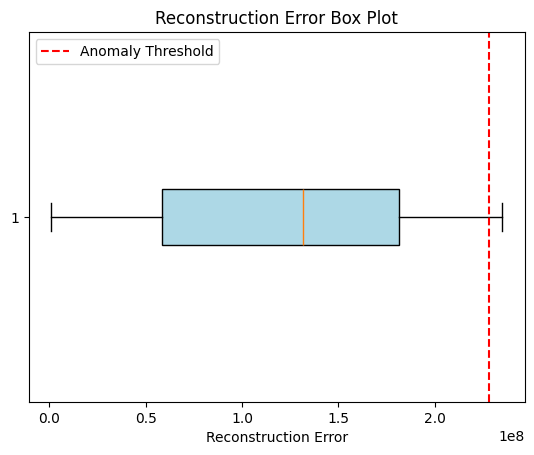

In [14]:
# Plot Reconstruction Error Distribution
plt.boxplot(reconstruction_error, vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.axvline(x=threshold, color='red', linestyle='--', label='Anomaly Threshold')
plt.title('Reconstruction Error Box Plot')
plt.xlabel('Reconstruction Error')
plt.legend()
plt.show()

2.5. Ensemble Approach

In [17]:
# Combine models using weighted average
data['Ensemble_Score'] = (0.4 * data['IsoForest_Score'] +
                          0.3 * data['Autoencoder_Reconstruction_Error'])

# Normalize ensemble scores for comparison
data['Ensemble_Score_Normalized'] = (data['Ensemble_Score'] - data['Ensemble_Score'].min()) / \
                                    (data['Ensemble_Score'].max() - data['Ensemble_Score'].min())

# Save results
data.to_csv('anomaly_detection_results.csv', index=False)

print("Modeling and anomaly detection completed. Results saved.")

Modeling and anomaly detection completed. Results saved.
